In [18]:
import pprint
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)


import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error as mae
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

In [19]:
client = MongoClient(host="localhost", port=27017)
db = client["air-quality"]
col = db["india"]

In [20]:
col.find_one()

{'_id': ObjectId('67f54f743fc4bf1cdcc605cf'),
 'City': 'Ahmedabad',
 'Datetime': '1/1/2015 1:00',
 'PM2': '',
 'PM10': '',
 'NO': '1',
 'NO2': '40.01',
 'NOx': '36.37',
 'NH3': '',
 'CO': '1',
 'SO2': '122.07',
 'O3': '',
 'Benzene': '0',
 'Toluene': '0',
 'Xylene': '0',
 'AQI': '',
 'AQI_Bucket': ''}

In [27]:
def wrangle(collection):
    results = collection.find({
        "City": "Bengaluru"
    }, projection = {
        "Datetime": 1, "PM2": 1, "_id": 0
    })
    
    df = pd.DataFrame(results).set_index("Datetime")
    
    # Filter to only data from 2020
    df.index = pd.to_datetime(df.index)
    df = df[~df.index.year.isin(range(2015, 2020))]
    
    # Filter to Ahmedabab tz
    df.index = df.index.tz_localize("UTC").tz_convert("Asia/Kolkata")
    
    # Convert PM2 to floating point number
    df["PM2"] = df["PM2"].astype(float)
    
    # Remove outliers
    df = df[df["PM2"] < 140]
    
    # Drop all null values
    df.dropna(inplace=True)
    

    return df

In [28]:
df = wrangle(col)
df.head()

,PM2
Datetime,
2020-01-01 05:30:00+05:30,42.06
2020-01-01 06:30:00+05:30,42.11
2020-01-01 07:30:00+05:30,46.64
2020-01-01 08:30:00+05:30,38.83
2020-01-01 09:30:00+05:30,34.95


In [29]:
y = df["PM2"].resample("1H").mean().fillna(method="ffill")
y.head()

Datetime
2020-01-01 05:00:00+05:30    42.06
2020-01-01 06:00:00+05:30    42.11
2020-01-01 07:00:00+05:30    46.64
2020-01-01 08:00:00+05:30    38.83
2020-01-01 09:00:00+05:30    34.95
Freq: H, Name: PM2, dtype: float64

In [30]:
y.corr(y.shift(6))

0.3559320685182143

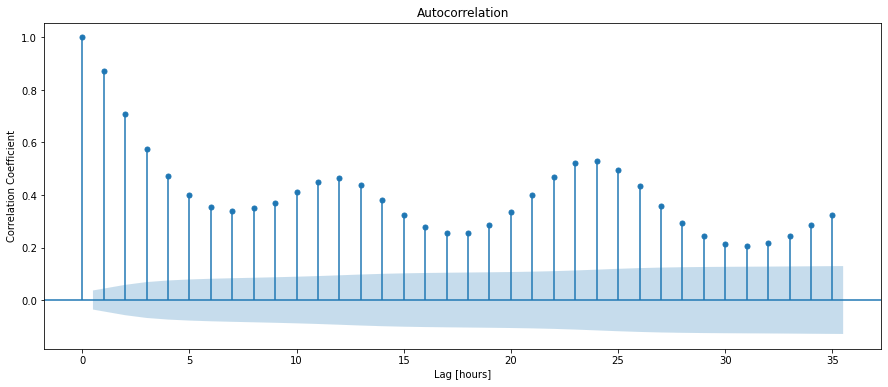

In [31]:
# plot Autocorrelation function graph
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

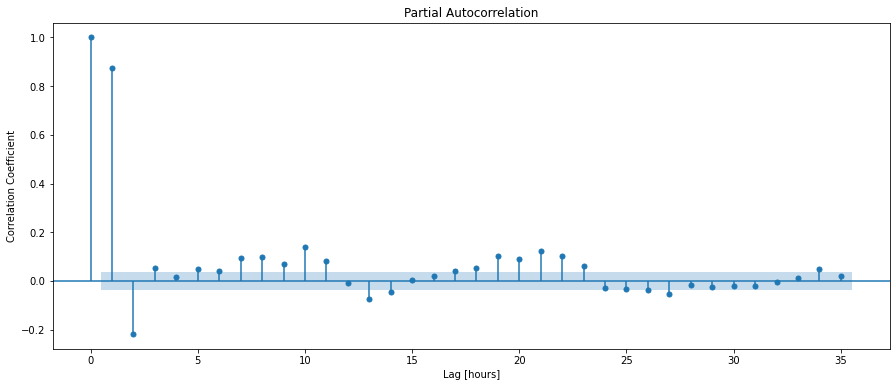

In [32]:
# plot Autocorrelation function graph
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

In [33]:
# train test split
cutoff = int(len(y) * 0.8)
y_train = y[:cutoff]
y_test = y[cutoff:]

In [34]:
# calculate baseline mae
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mae(y_train, y_pred_baseline)
baseline_mae

11.748609954941477

In [35]:
model = AutoReg(y_train, lags=26).fit()

In [36]:
#make prediction using the walk forward validation model
y_pred_train = model.predict().dropna()

In [37]:
#Calculate training mean absolute error
training_mae = mae(y_train[26:], y_pred_train)
training_mae

4.122988562692135

In [38]:
# Predict with test data using walk forward validation
y_pred_test_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=26).fit()
    next_pred = model.forecast()
    y_pred_test_wfv = y_pred_test_wfv.append(next_pred)
    history = history.append(y_test[[i]])
    
y_pred_test_wfv.head()

2020-04-07 01:00:00+05:30    26.656148
2020-04-07 02:00:00+05:30    29.895046
2020-04-07 03:00:00+05:30    26.020374
2020-04-07 04:00:00+05:30    36.669412
2020-04-07 05:00:00+05:30    28.526657
Freq: H, dtype: float64

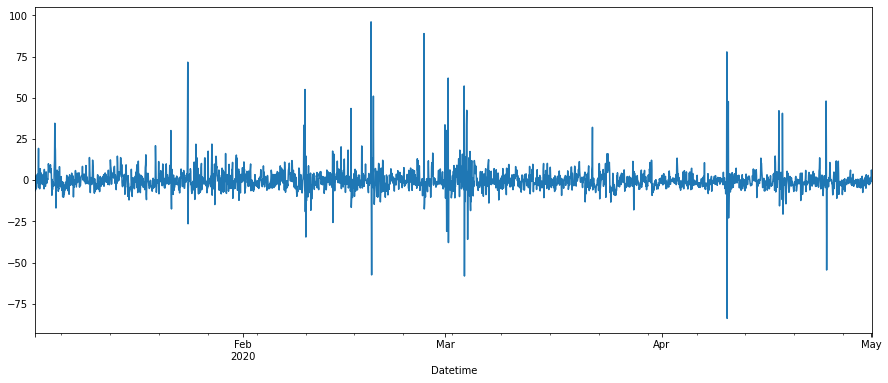

In [39]:
plt.subplots(figsize=(15,6))
model.resid.plot();

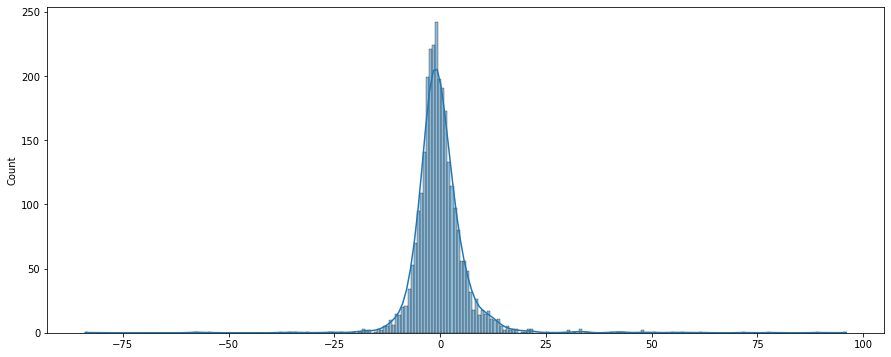

In [40]:
# Confirm most of the residuals are centered at 0 using a normal distribution
plt.subplots(figsize=(15,6))
sns.histplot(model.resid, kde=True);

In [41]:
#calculate test mean absolute error
test_mae = mae(y_test, y_pred_test_wfv)
test_mae

3.641938525042306

In [42]:
print(f"""
Baseline Mae = {baseline_mae}
Train Mae = {training_mae}
Test Mae = {test_mae}
""")


Baseline Mae = 11.748609954941477
Train Mae = 4.122988562692135
Test Mae = 3.641938525042306



In [43]:
# put both predicted value and actual value in a dataframe
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test_wfv}, index=y_test.index
)
df_pred_test.head()

,y_test,y_pred
Datetime,,
2020-04-07 01:00:00+05:30,28.14,26.656148
2020-04-07 02:00:00+05:30,25.76,29.895046
2020-04-07 03:00:00+05:30,36.19,26.020374
2020-04-07 04:00:00+05:30,30.67,36.669412
2020-04-07 05:00:00+05:30,24.77,28.526657


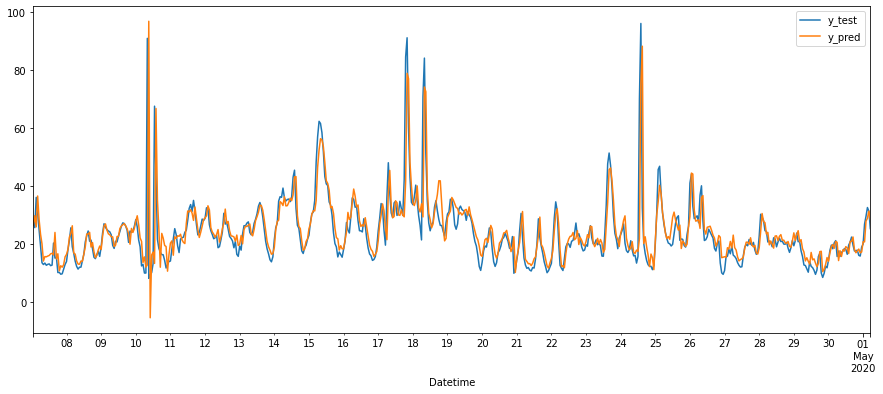

In [44]:
# time series plot for the true value and predicted value of ytest
fig, ax = plt.subplots(figsize=(15,6))
df_pred_test.plot(ax=ax);